# Plot the ClassyFire Molecule Classes against the Ranking-changes (improvements)

For each MS-tuple in MassBank the ClassyFire molecule class (superclass- and class-level) has been determined. We also can provide the rank of the correct molecular structure within each candidate set for each MS-tuple. Two rankings are given: 

1) **Only MS**: Candidates are ranked based on the respective MS2 scoring method (MetFrag, SIRIUS or CFM-ID)
2) **LC-MS$^2$Struct**: Ranking based on the max-marginals integrating the MS2 and retention order (RO) scores

The analysis here consideres the rank-improvements (LC-MS$^2$Struct over Only MS) aggregated for each ClassyFire class, i.e. at superclass-level or class-level.

For the **LC-MS$^2$Struct** ranking we aggregated eight (8) marginals by averaging the output of eight (8) different SSVM.

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import itertools as it

from typing import Union, List, Optional

# RDKIT
from rdkit.Chem import MolFromSmiles, Draw
from rdkit.Chem.rdDepictor import Compute2DCoords
from rdkit.Chem.Draw import IPythonConsole

from ssvm_evaluation.utils import dict2fn
from ssvm_evaluation.plotting_utils import plot__02__a, plot__02__b

## Load Results

Candidate scores are aggregated by **InChIKey**.

In [3]:
def ndarray_converter(x: str):
    """
    Convert list with two items stored an a CSV as string into an NumPy array. 
    """
    rmin, rmax = x.strip("[]").split(",")
    return np.array([int(rmin), int(rmax)], dtype=int)
    

In [4]:
agg_setting = {
    "marg_agg_fun": "average",
    "cand_agg_id": "inchikey1"
}

### MetFrag

In [5]:
df = pd.DataFrame()

setting = {
    "ds": "*",
    "mol_feat": "FCFP__binary__all__2D",
    "mol_id": "cid",
    "ms2scorer": "metfrag__norm",
    "ssvm_flavor": "default",
    "lloss_mode": "mol_feat_fps"
}

for fn in glob.iglob(os.path.join("massbank", dict2fn(setting), dict2fn(agg_setting, pref="combined"), "rank_improvements__csi.tsv")):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                fn, sep="\t", converters={"rank_onlyms": ndarray_converter, "rank_msplrt": ndarray_converter}
            ).assign(ms2scorer="MetFrag")
        ), 
        ignore_index=True
    )

### SIRIUS

In [6]:
setting = {
    "ds": "*",
    "mol_feat": "FCFP__binary__all__2D",
    "mol_id": "cid",
    "ms2scorer": "sirius__norm",
    "ssvm_flavor": "default",
    "lloss_mode": "mol_feat_fps"
}

for fn in glob.iglob(os.path.join("massbank", dict2fn(setting), dict2fn(agg_setting, pref="combined"), "rank_improvements__csi.tsv")):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                fn, sep="\t", converters={"rank_onlyms": ndarray_converter, "rank_msplrt": ndarray_converter}
            ).assign(ms2scorer="SIRIUS")
        ), 
        ignore_index=True
    )

### CFM-ID

In [7]:
setting = {
    "ds": "*",
    "mol_feat": "FCFP__binary__all__2D",
    "mol_id": "cid",
    "ms2scorer": "cfmid4__norm",
    "ssvm_flavor": "default",
    "lloss_mode": "mol_feat_fps"
}

for fn in glob.iglob(os.path.join("massbank", dict2fn(setting), dict2fn(agg_setting, pref="combined"), "rank_improvements__csi.tsv")):
    df = pd.concat(
        (
            df,
            pd.read_csv(
                fn, sep="\t", converters={"rank_onlyms": ndarray_converter, "rank_msplrt": ndarray_converter}
            ).assign(ms2scorer="CFM-ID")
        ), 
        ignore_index=True
    )

## Plot Results 

### Performance for individual ClassyFire super-classes

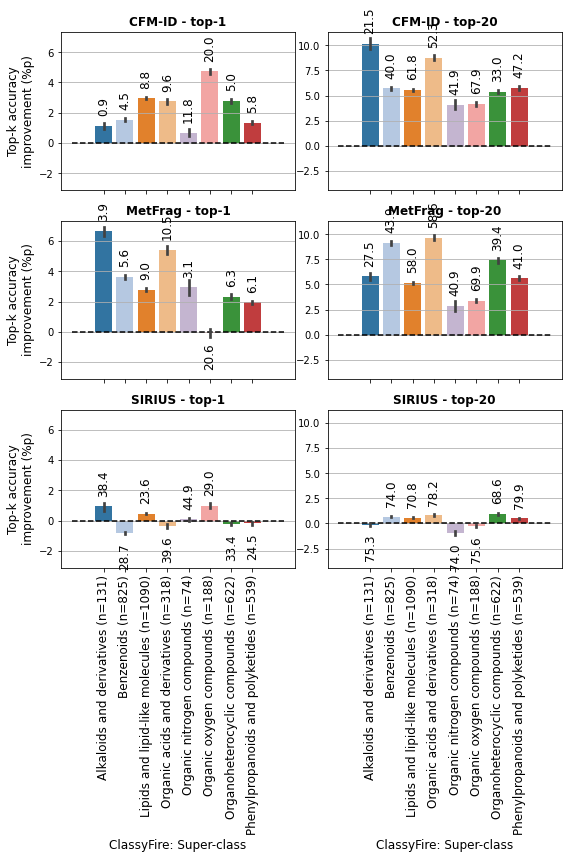

In [8]:
tmp = {}

tmp["superclass"], superlevel = plot__02__a(
    df, min_class_support=50, ks=[1, 20], sharey="col", topk_method="csi", fig_width=4, fig_height=4, colormap_name="fixed", 
    cf_level="superclass", label_rot_angle=90, n_samples=50
)    

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_02__a", ext])))

In [9]:
__a__ = tmp["superclass"][(tmp["superclass"]["k"] == 1) & (tmp["superclass"]["ms2scorer"] == "CFM-ID")].round(1)
# print(np.array(__a__["top_k_p_improvement"].tolist()) @ np.array(__a__["n_class_support"].tolist()) / __a__["n_class_support"].sum())
__a__

,classyfire_superclass,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
0,Alkaloids and derivatives,0.9,2.0,1.1,4979.0,"min=1, max=123, avg=16.2, med=11.0",131,1,CFM-ID,1.5
1,Benzenoids,4.5,6.0,1.5,989.0,"min=1, max=51, avg=2.3, med=1.0",825,1,CFM-ID,12.6
2,Lipids and lipid-like molecules,8.8,11.7,3.0,83.0,"min=1, max=244, avg=11.7, med=3.0",1090,1,CFM-ID,32.2
3,Organic acids and derivatives,9.6,12.4,2.8,619.5,"min=1, max=93, avg=5.8, med=3.0",318,1,CFM-ID,8.7
4,Organic nitrogen compounds,11.8,12.5,0.7,881.5,"min=1, max=18, avg=2.5, med=1.0",74,1,CFM-ID,0.5
5,Organic oxygen compounds,20.0,24.8,4.7,88.5,"min=1, max=154, avg=11.4, med=3.0",188,1,CFM-ID,8.9
6,Organoheterocyclic compounds,5.0,7.7,2.8,982.0,"min=1, max=101, avg=3.6, med=1.0",622,1,CFM-ID,17.3
7,Phenylpropanoids and polyketides,5.8,7.2,1.3,247.0,"min=1, max=113, avg=7.5, med=3.0",539,1,CFM-ID,7.3


In [10]:
__a__ = tmp["superclass"][(tmp["superclass"]["k"] == 1) & (tmp["superclass"]["ms2scorer"] == "MetFrag")].round(1)
# print(np.array(__a__["top_k_p_improvement"].tolist()) @ np.array(__a__["n_class_support"].tolist()) / __a__["n_class_support"].sum())
__a__

,classyfire_superclass,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
16,Alkaloids and derivatives,3.9,10.6,6.7,4979.0,"min=1, max=123, avg=16.2, med=11.0",131,1,MetFrag,8.7
17,Benzenoids,5.6,9.3,3.6,989.0,"min=1, max=51, avg=2.3, med=1.0",825,1,MetFrag,29.9
18,Lipids and lipid-like molecules,9.0,11.8,2.8,83.0,"min=1, max=244, avg=11.7, med=3.0",1090,1,MetFrag,30.5
19,Organic acids and derivatives,10.5,15.9,5.4,619.5,"min=1, max=93, avg=5.8, med=3.0",318,1,MetFrag,17.2
20,Organic nitrogen compounds,3.1,6.0,2.9,881.5,"min=1, max=18, avg=2.5, med=1.0",74,1,MetFrag,2.2
21,Organic oxygen compounds,20.6,20.5,-0.1,88.5,"min=1, max=154, avg=11.4, med=3.0",188,1,MetFrag,-0.1
22,Organoheterocyclic compounds,6.3,8.7,2.3,982.0,"min=1, max=101, avg=3.6, med=1.0",622,1,MetFrag,14.5
23,Phenylpropanoids and polyketides,6.1,8.0,1.9,247.0,"min=1, max=113, avg=7.5, med=3.0",539,1,MetFrag,10.5


In [11]:
__a__ = tmp["superclass"][(tmp["superclass"]["k"] == 1) & (tmp["superclass"]["ms2scorer"] == "SIRIUS")].round(1)
# print(np.array(__a__["top_k_p_improvement"].tolist()) @ np.array(__a__["n_class_support"].tolist()) / __a__["n_class_support"].sum())
__a__

,classyfire_superclass,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
32,Alkaloids and derivatives,38.4,39.4,0.9,4979.0,"min=1, max=123, avg=16.2, med=11.0",131,1,SIRIUS,1.2
33,Benzenoids,28.7,27.9,-0.8,989.0,"min=1, max=51, avg=2.3, med=1.0",825,1,SIRIUS,-6.8
34,Lipids and lipid-like molecules,23.6,24.1,0.5,83.0,"min=1, max=244, avg=11.7, med=3.0",1090,1,SIRIUS,5.1
35,Organic acids and derivatives,39.6,39.3,-0.4,619.5,"min=1, max=93, avg=5.8, med=3.0",318,1,SIRIUS,-1.2
36,Organic nitrogen compounds,44.9,45.0,0.1,881.5,"min=1, max=18, avg=2.5, med=1.0",74,1,SIRIUS,0.1
37,Organic oxygen compounds,29.0,30.0,1.0,88.5,"min=1, max=154, avg=11.4, med=3.0",188,1,SIRIUS,1.9
38,Organoheterocyclic compounds,33.4,33.2,-0.2,982.0,"min=1, max=101, avg=3.6, med=1.0",622,1,SIRIUS,-1.3
39,Phenylpropanoids and polyketides,24.5,24.3,-0.2,247.0,"min=1, max=113, avg=7.5, med=3.0",539,1,SIRIUS,-1.0


### Performance for individual ClassyFire classes

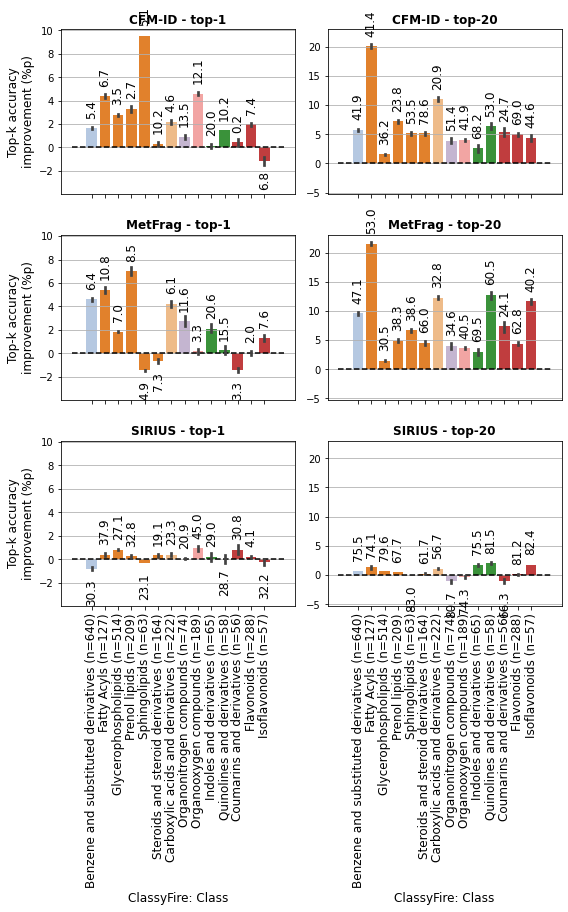

In [11]:
tmp["class"], superlevel = plot__02__a(
    df, min_class_support=50, ks=[1, 20], sharey="col", topk_method="csi", fig_width=4, fig_height=4.25, colormap_name="fixed", 
    cf_level="class", label_rot_angle=90, n_samples=50
)    

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["extended_data__plot_02__a__class_level", ext])))

### PubChemLite classes

In [1]:
tmp["pubchemlite"] = plot__02__b(
    df, min_class_support=50, ks=[1, 20], sharey="col", topk_method="csi", fig_width=4, fig_height=3.5, n_samples=50
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_02__b", ext])))

NameError: name 'plot__02__b' is not defined

In [17]:
tmp["pubchemlite"][(tmp["pubchemlite"]["k"] == 1) & (tmp["pubchemlite"]["ms2scorer"] == "CFM-ID")].round(1)

,pubchemlite_class,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
0,agroChemInfo,9.4,10.8,1.5,537.0,1,513,1,CFM-ID,7.5
1,bioPathway,5.6,8.3,2.7,540.0,3,2090,1,CFM-ID,56.3
2,disorderDisease,4.6,7.1,2.5,697.0,3,1324,1,CFM-ID,33.2
3,drugMedicInfo,4.2,6.0,1.8,905.0,3,930,1,CFM-ID,16.7
4,foodRelated,5.6,9.3,3.7,684.0,1,380,1,CFM-ID,14.1
5,identification,5.9,7.5,1.7,728.0,1,801,1,CFM-ID,13.3
6,knownUse,6.4,9.1,2.8,569.0,3,2459,1,CFM-ID,68.0
7,noClassification,10.4,12.6,2.2,94.0,1,821,1,CFM-ID,18.4
8,pharmacoInfo,6.6,9.2,2.6,461.0,3,2395,1,CFM-ID,62.2
9,safetyInfo,4.9,7.3,2.4,800.5,1,1980,1,CFM-ID,47.8


In [18]:
tmp["pubchemlite"][(tmp["pubchemlite"]["k"] == 1) & (tmp["pubchemlite"]["ms2scorer"] == "MetFrag")].round(1)

,pubchemlite_class,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
22,agroChemInfo,9.0,14.9,5.9,537.0,1,513,1,MetFrag,30.1
23,bioPathway,5.4,8.8,3.4,540.0,3,2090,1,MetFrag,70.7
24,disorderDisease,3.7,6.9,3.2,697.0,3,1324,1,MetFrag,43.0
25,drugMedicInfo,4.0,6.8,2.8,905.0,3,930,1,MetFrag,26.2
26,foodRelated,2.7,6.6,3.9,684.0,1,380,1,MetFrag,14.8
27,identification,4.1,8.6,4.5,728.0,1,801,1,MetFrag,36.2
28,knownUse,5.6,9.3,3.8,569.0,3,2459,1,MetFrag,92.7
29,noClassification,14.1,16.1,1.9,94.0,1,821,1,MetFrag,15.7
30,pharmacoInfo,6.4,9.9,3.5,461.0,3,2395,1,MetFrag,83.7
31,safetyInfo,4.4,8.1,3.7,800.5,1,1980,1,MetFrag,73.7


In [19]:
tmp["pubchemlite"][(tmp["pubchemlite"]["k"] == 1) & (tmp["pubchemlite"]["ms2scorer"] == "SIRIUS")].round(1)

,pubchemlite_class,top_k_p_onlyms,top_k_p_msplrt,top_k_p_improvement,n_cand,n_isomers,n_class_support,k,ms2scorer,improvement_in_n
44,agroChemInfo,36.5,36.6,0.1,537.0,1,513,1,SIRIUS,0.7
45,bioPathway,33.4,33.6,0.2,540.0,3,2090,1,SIRIUS,3.1
46,disorderDisease,36.6,36.7,0.0,697.0,3,1324,1,SIRIUS,0.7
47,drugMedicInfo,38.7,38.7,0.0,905.0,3,930,1,SIRIUS,0.3
48,foodRelated,36.4,36.1,-0.3,684.0,1,380,1,SIRIUS,-1.3
49,identification,40.0,40.0,0.0,728.0,1,801,1,SIRIUS,0.1
50,knownUse,33.2,33.3,0.1,569.0,3,2459,1,SIRIUS,1.6
51,noClassification,20.3,20.2,-0.1,94.0,1,821,1,SIRIUS,-1.1
52,pharmacoInfo,33.4,33.5,0.1,461.0,3,2395,1,SIRIUS,1.7
53,safetyInfo,34.6,34.5,-0.1,800.5,1,1980,1,SIRIUS,-2.7
